In [2]:
# imports
%cd '/home/naodell/work/wbr/analysis'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scripts.plot_tools as pt
from seaborn import heatmap
pt.set_default_style()

/home/naodell/work/wbr/analysis


## parton based rescaling

In [3]:
selection = 'mumu'
input_dir = f'local_data/flatuples/z_cr_partons/{selection}_2016'
datasets = ['zjets_m-50', 'zjets_m-50_alt']
dm = pt.DataManager(input_dir     = input_dir,
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 1,
                    cuts          = 'dilepton1_mass > 50 and lepton1_q != lepton2_q',
                    combine       = False
                   )

# scale weights to account for using a subset of full MC
event_counts = pd.read_csv(f'{input_dir}/event_counts.csv').iloc[4]
df_scaled = dict()
for ds in datasets:
    df = dm.get_dataframe(ds).copy()
    df.weight *= event_counts[ds]/df.shape[0]
    df_scaled[ds] = df.query('n_jets >= 0 and n_bjets == 0')

Loading dataframes: 100%|███████████████| 4.00/4.00 [01:25<00:00, 25.7s/it]


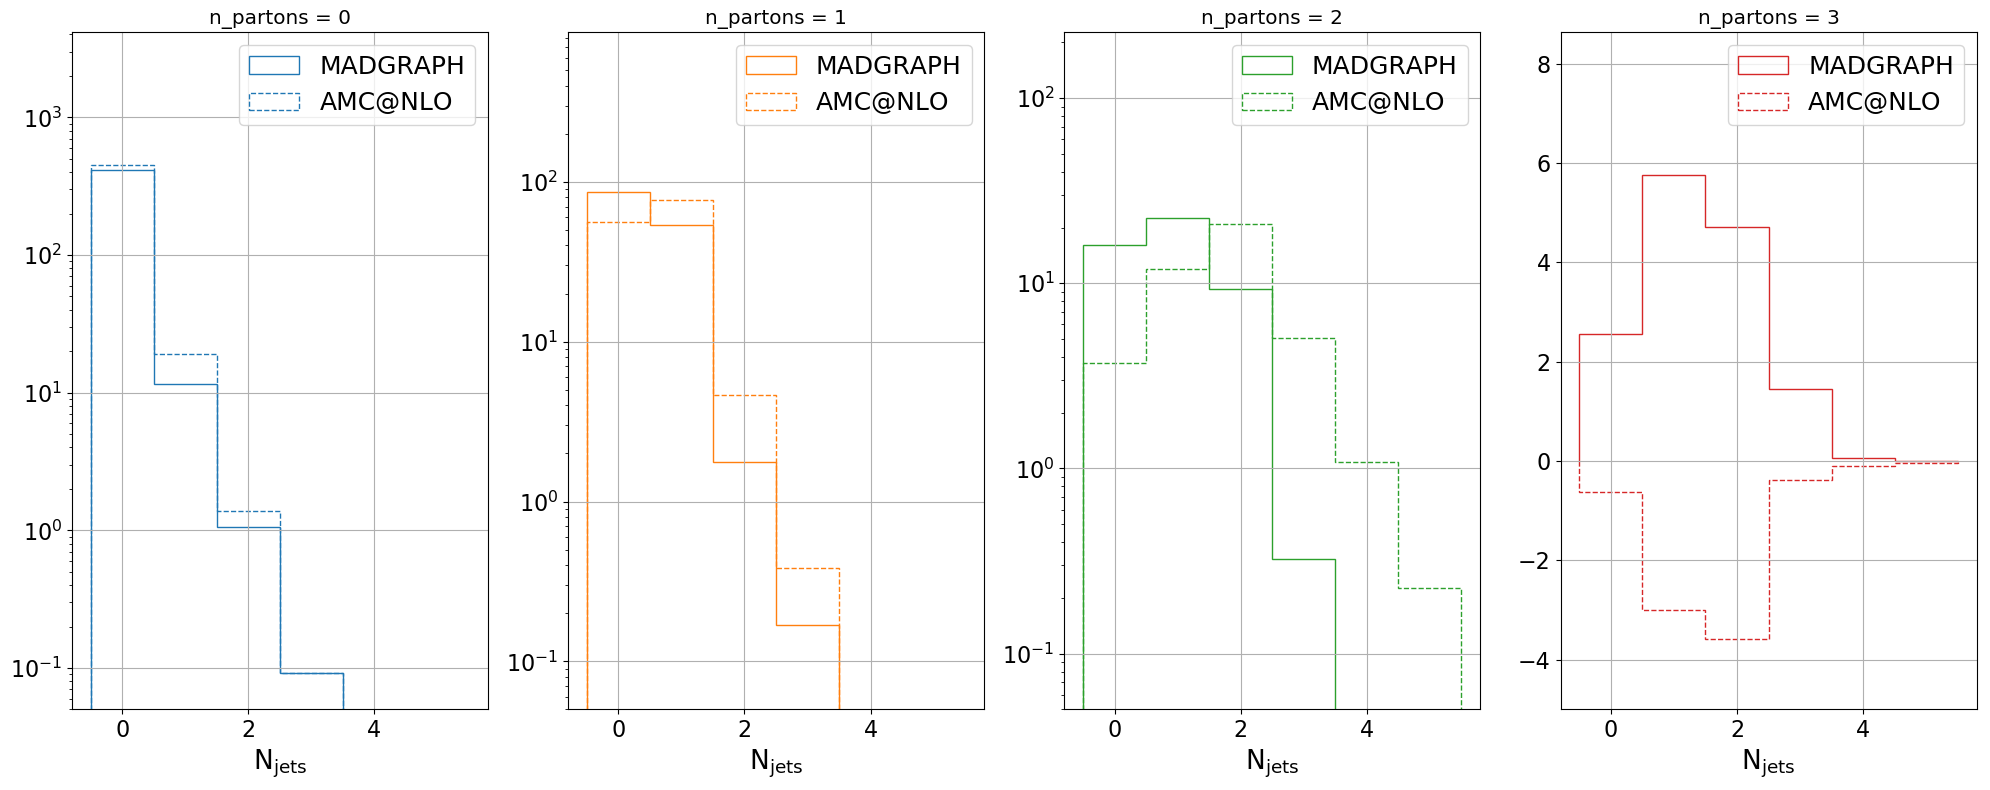

In [71]:
# make the plot
#fix, ax = plt.subplots(1, 1, figsize=(8,6))
fix, axes = plt.subplots(1, 4, figsize=(20, 8))

bins = np.arange(-0.5, 6.5, 1)
g_lo = df_scaled['zjets_m-50'].groupby('n_partons')
g_nlo = df_scaled['zjets_m-50_alt'].groupby('n_partons')
colors = ['C0', 'C1', 'C2', 'C3']
#ax.hist([g.get_group(i).n_jets for i in range(4)], bins=bins, color=colors, linestyle='-', histtype='step', stacked=False, weights=[g.get_group(i).weight for i in range(4)])
#ax.hist([g.get_group(i).n_jets for i in range(4)], bins=bins, color=colors, linestyle='--', histtype='step', stacked=False, weights=[g.get_group(i).weight for i in range(4)])
for i in range(4):
    ax = axes[i]
    h, _, _ = ax.hist(g_lo.get_group(i).n_jets, bins=bins, color=colors[i], linestyle='-', histtype='step', weights=g_lo.get_group(i).weight)
    ax.hist(g_nlo.get_group(i).n_jets, bins=bins, color=colors[i], linestyle='--', histtype='step', weights=g_nlo.get_group(i).weight)
    ax.set_title(f'n_partons = {i}')
    ax.set_xlabel('$\sf N_{jets}$')
    if i < 3:
        ax.set_ylim(0.05, 10*np.max(h))
        ax.set_yscale('log')
    else:
        ax.set_ylim(np.min(h) - 5, 1.5*np.max(h))
        ax.set_yscale('linear')
    ax.grid()
    ax.legend(['MADGRAPH', 'AMC@NLO'])#, 'MADGRAPH (reweighted)'])

plt.tight_layout()
plt.savefig(f'plots/dy_comparisons/test.pdf')
plt.show()

## data to MC comparisons

In [2]:
selection = 'mumu'

# get the amc@nlo DY sample
datasets = [                                                          
            'zjets_m-50_alt',                                         
            'zjets_m-50',  'z1jets_m-50', 'z2jets_m-50', 'z3jets_m-50', 'z4jets_m-50',                                            
            'ttbar_lep',
            'muon_2016H'                                              
            ]                                                         

dm = pt.DataManager(input_dir     = f'local_data/flatuples/z_cr/{selection}_2016',
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 9.2e3,
                    cuts          = 'dilepton1_mass > 50 and lepton1_q != lepton2_q',
                    combine       = False
                   )

Loading dataframes: 100%|███████████████| 8.00/8.00 [05:30<00:00, 41.3s/it]


In [3]:
# scale weights to account for using a subset of full MC
event_counts = pd.read_csv(f'local_data/flatuples/z_cr/{selection}_2016/event_counts.csv').iloc[4]
df_scaled = dict()
for ds in datasets:
    df = dm.get_dataframe(ds).copy()
    if 'muon' not in ds:
        df.weight *= event_counts[ds]/df.shape[0]
    df_scaled[ds] = df.query('n_jets >= 0 and n_bjets == 0')


/home/naodell/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


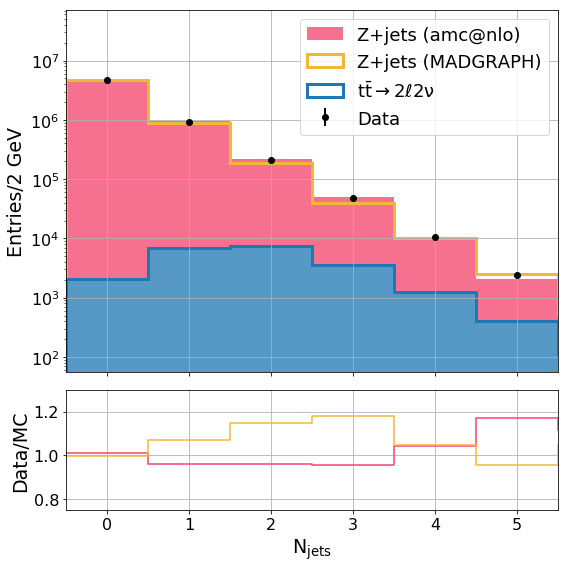

In [4]:
# make the plot
do_log = True
fig, axes = plt.subplots(2, 1, figsize=(8, 8), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3, 1]})

feature = 'n_jets'
bins = np.arange(-0.5, 7.5, 1.)
styles = dm._lut_datasets

ax = axes[0]
#h_data, _, _ = ax.hist(df_scaled['muon_2016H'][feature], label='Data', bins=bins, color='k', linewidth=2, histtype='step')
x, y, yerr = pt.hist_to_errorbar(df_scaled['muon_2016H'][feature], bins=bins)
mask = y>0
eb = ax.errorbar(x[mask], y[mask], yerr=yerr[mask],
                 fmt = 'ko',
                 capsize = 0,
                 elinewidth = 2,
                 label='Data'
                )

stack_labels = ['ttbar_lep', 'zjets_m-50_alt']
stack = [df_scaled[ds][feature] for ds in stack_labels]
weights = [df_scaled[ds]['weight'] for ds in stack_labels]
colors = [styles.loc[ds].color for ds in stack_labels]
labels = [styles.loc[ds].text for ds in stack_labels]
labels[0] = '_nolegend_'
h_nlo, b, _ = ax.hist(stack, bins=bins, color=colors, label=labels, linewidth=2, histtype='stepfilled', alpha=0.75, stacked=True, weights=weights)

stack_labels = ['ttbar_lep', 'zjets_m-50']
stack = [df_scaled[ds][feature] for ds in stack_labels]
weights = [df_scaled[ds]['weight'] for ds in stack_labels]
colors = [styles.loc[ds].color for ds in stack_labels]
labels = [styles.loc[ds].text for ds in stack_labels]
h_mg, b, _ = ax.hist(stack, bins=bins, color=colors, label=labels, linewidth=3, histtype='step', stacked=True, weights=weights)

ax.grid()
if do_log:
    ax.set_yscale('log')
    ax.set_ylim(max(0.1, 0.1*y.min()), 15*y.max())
else:
    ax.set_ylim(0., 1.5*y.max())
ax.set_ylabel('Entries/2 GeV')
ax.legend()

ax = axes[1]
ratio_nlo = y/h_nlo[-1]
ratio_mg = y/h_mg[-1]
ax.plot(bins[:-1], ratio_nlo, c=styles.loc['zjets_m-50_alt'].color, drawstyle='steps-post')
ax.plot(bins[:-1], ratio_mg, c=styles.loc['zjets_m-50'].color, drawstyle='steps-post')
ax.set_xlabel(f'$\sf {dm._lut_features.loc[feature].x_label}$')
ax.set_xlim(bins[0], bins[-2])
ax.set_ylim(0.75, 1.3)
ax.set_ylabel('Data/MC')
ax.grid()

plt.tight_layout()
plt.savefig(f'plots/dy_comparisons/{feature}.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


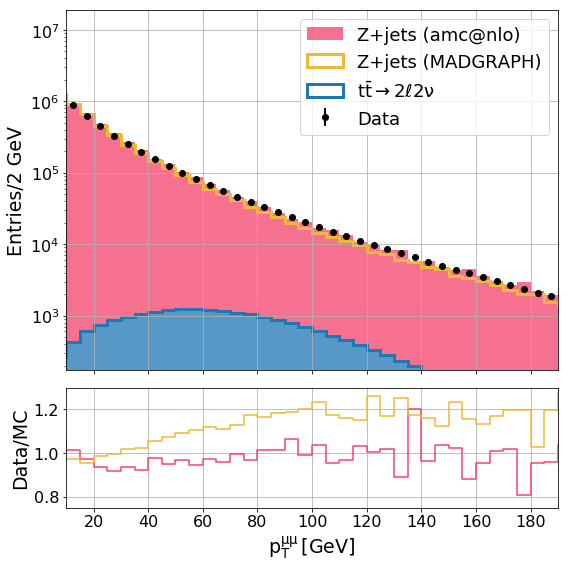

In [5]:
# make the plot
do_log = True
fig, axes = plt.subplots(2, 1, figsize=(8, 8), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3, 1]})

feature = 'dilepton1_pt'
bins = np.arange(0., 200., 5)
styles = dm._lut_datasets

ax = axes[0]
#h_data, _, _ = ax.hist(df_scaled['muon_2016H'][feature], label='Data', bins=bins, color='k', linewidth=2, histtype='step')
x, y, yerr = pt.hist_to_errorbar(df_scaled['muon_2016H'][feature], bins=bins)
mask = y>0
eb = ax.errorbar(x[mask], y[mask], yerr=yerr[mask],
                 fmt = 'ko',
                 capsize = 0,
                 elinewidth = 2,
                 label='Data'
                )

stack_labels = ['ttbar_lep', 'zjets_m-50_alt']
stack = [df_scaled[ds][feature] for ds in stack_labels]
weights = [df_scaled[ds]['weight'] for ds in stack_labels]
colors = [styles.loc[ds].color for ds in stack_labels]
labels = [styles.loc[ds].text for ds in stack_labels]
labels[0] = '_nolegend_'
h_nlo, b, _ = ax.hist(stack, bins=bins, color=colors, label=labels, linewidth=2, histtype='stepfilled', alpha=0.75, stacked=True, weights=weights)

stack_labels = ['ttbar_lep', 'zjets_m-50']
stack = [df_scaled[ds][feature] for ds in stack_labels]
weights = [df_scaled[ds]['weight'] for ds in stack_labels]
colors = [styles.loc[ds].color for ds in stack_labels]
labels = [styles.loc[ds].text for ds in stack_labels]
h_mg, b, _ = ax.hist(stack, bins=bins, color=colors, label=labels, linewidth=3, histtype='step', stacked=True, weights=weights)

ax.grid()
if do_log:
    ax.set_yscale('log')
    ax.set_ylim(max(0.1, 0.1*y.min()), 15*y.max())
else:
    ax.set_ylim(0., 1.5*y.max())
ax.set_ylabel('Entries/2 GeV')
ax.legend()

ax = axes[1]
ratio_nlo = y/h_nlo[-1]
ratio_mg = y/h_mg[-1]
ax.plot(bins[:-1], ratio_nlo, c=styles.loc['zjets_m-50_alt'].color, drawstyle='steps-post')
ax.plot(bins[:-1], ratio_mg, c=styles.loc['zjets_m-50'].color, drawstyle='steps-post')
ax.set_xlabel(f'$\sf {dm._lut_features.loc[feature].x_label}$')
ax.set_xlim(bins[2], bins[-2])
ax.set_ylim(0.75, 1.3)
ax.set_ylabel('Data/MC')
ax.grid()

plt.tight_layout()
plt.savefig(f'plots/dy_comparisons/{feature}.pdf')
plt.show()